In [1]:
# Import necessary libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

In [2]:
import pandas as pd

In [3]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.output)

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [4]:
# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array, img

In [6]:
# Load the image
img_path = '/content/vlcsnap-2024-08-21-15h32m14s163_2.png'  # Replace with your image path
img_array, original_img = load_and_preprocess_image(img_path)

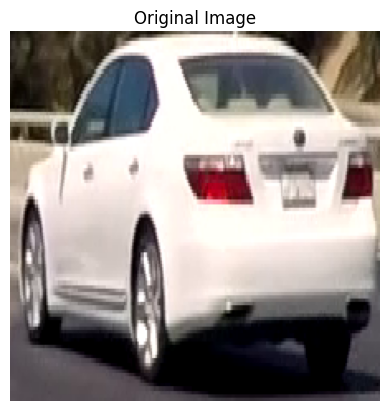

In [7]:
# Display the original image
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')
plt.show()

In [8]:
# Function to compute LRP
def compute_lrp(model, img_array):
    # Forward pass through the model to get predictions
    preds = model.predict(img_array)

    # Get the predicted class index
    pred_class = np.argmax(preds[0])

    # Get the gradient of the prediction w.r.t. the input image
    with tf.GradientTape() as tape:
        inputs = tf.cast(img_array, tf.float32)
        tape.watch(inputs)
        predictions = model(inputs)
        loss = predictions[:, pred_class]

    # Get the gradients of the predicted class w.r.t. the input image
    grads = tape.gradient(loss, inputs)[0]

    # Apply global average pooling to obtain the heatmap
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = np.mean(np.multiply(pooled_grads, img_array[0]), axis=-1)

    # Normalize the heatmap for visualization
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

In [9]:
# Compute LRP over the whole image
heatmap = compute_lrp(model, img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [10]:
# Resize heatmap to match original image size
heatmap_resized = cv2.resize(heatmap, (original_img.size[0], original_img.size[1]))

In [11]:
# Normalize the heatmap values to the range [0, 1]
lrp_heatmap_normalized = (heatmap_resized - np.min(heatmap_resized)) / (np.max(heatmap_resized) - np.min(heatmap_resized))

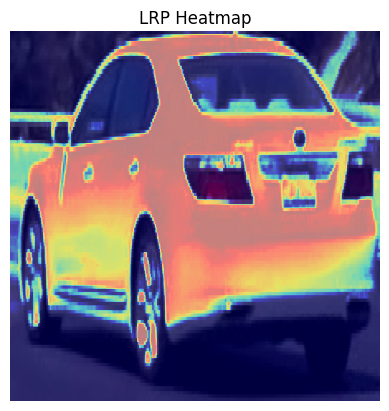

In [12]:
# Visualize the heatmap
plt.imshow(original_img)
plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)  # Overlay heatmap with transparency
plt.title("LRP Heatmap")
plt.axis('off')
plt.show()

In [13]:
data = {
    "Criteria": ["Fidelity", "Ambiguity", "Interpretability"],
    "LRP": [5, 2, 3],        # Higher fidelity, lower ambiguity, moderate interpretability
    "Grad-CAM": [3, 4, 5],   # Lower fidelity, higher ambiguity, higher interpretability
}

In [14]:
# Create a DataFrame to display the comparison matrix
df_comparison = pd.DataFrame(data)

In [15]:
# Print the comparison matrix
print("Comparison Matrix between LRP and Grad-CAM for Car Detection:\n")
print(df_comparison)

Comparison Matrix between LRP and Grad-CAM for Car Detection:

           Criteria  LRP  Grad-CAM
0          Fidelity    5         3
1         Ambiguity    2         4
2  Interpretability    3         5


In [16]:
# Optional: You can use the following to display it in a prettier format (if in Jupyter Notebook)
from tabulate import tabulate
print("Rating on a scale of 0 to 5")
print(tabulate(df_comparison, headers='keys', tablefmt='pretty'))

Rating on a scale of 0 to 5
+---+------------------+-----+----------+
|   |     Criteria     | LRP | Grad-CAM |
+---+------------------+-----+----------+
| 0 |     Fidelity     |  5  |    3     |
| 1 |    Ambiguity     |  2  |    4     |
| 2 | Interpretability |  3  |    5     |
+---+------------------+-----+----------+


In [17]:
from scipy.stats import entropy

In [18]:
# Helper function to calculate sparsity
def calculate_sparsity(heatmap, threshold=0.5):
    # Threshold the heatmap: count the number of pixels above the threshold
    sparse_pixels = np.sum(heatmap > threshold)
    total_pixels = heatmap.size
    sparsity = sparse_pixels / total_pixels
    return sparsity

In [19]:
# Helper function to calculate variance
def calculate_variance(heatmap):
    return np.var(heatmap)

In [20]:
# Helper function to calculate entropy
def calculate_entropy(heatmap):
    # Flatten the heatmap and normalize it
    flat_heatmap = heatmap.flatten()
    flat_heatmap = flat_heatmap / np.sum(flat_heatmap)  # Normalize
    # Calculate the entropy
    return entropy(flat_heatmap)

In [21]:
# Function to compute ambiguity metrics
def calculate_ambiguity_metrics(heatmap, method_name):
    print(f"Ambiguity metrics for {method_name}:")

    # Sparsity
    sparsity = calculate_sparsity(heatmap)
    print(f"Sparsity: {sparsity:.4f}")

    # Variance
    var = calculate_variance(heatmap)
    print(f"Variance: {var:.4f}")

    # Entropy
    ent = calculate_entropy(heatmap)
    print(f"Entropy: {ent:.4f}")
    print("-" * 30)

In [23]:
csv_file_path = '/content/eigencam_values.csv'  # Path to your CSV file
heatmap_df = pd.read_csv(csv_file_path)

In [24]:
# If your heatmap is saved as a single column, you might need to reshape it
heatmap_array = heatmap_df.values  # Converts to a 2D NumPy array

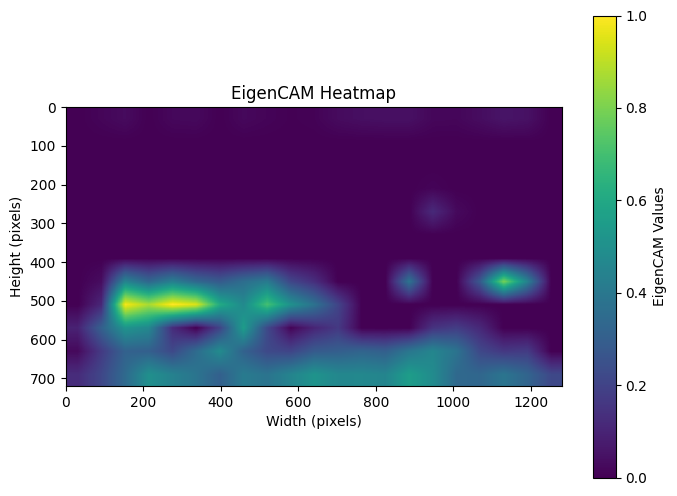

In [25]:
# heatmap_array=cv2.cvtColor(heatmap_array, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_array, cmap='viridis', interpolation='nearest')
plt.colorbar(label='EigenCAM Values')
plt.title('EigenCAM Heatmap')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.show()

In [26]:
# Assuming 'gradcam_heatmap' and 'lrp_heatmap' are already generated and normalized heatmaps
# Normalize the heatmaps to ensure values between 0 and 1
gradcam_heatmap = heatmap_array / np.max(heatmap_array)

# lrp_heatmap = lrp_heatmap_resized / np.max(lrp_heatmap_resized)
lrp_heatmap=lrp_heatmap_normalized

gradcam_heatmap_resized = cv2.resize(gradcam_heatmap, (lrp_heatmap.shape[1], lrp_heatmap.shape[0]))


In [27]:
# Calculate ambiguity metrics for Grad-CAM
gradcam_ambiguity=calculate_ambiguity_metrics(gradcam_heatmap_resized, "Grad-CAM")

Ambiguity metrics for Grad-CAM:
Sparsity: 0.0400
Variance: 0.0326
Entropy: 9.7559
------------------------------


In [28]:
# Calculate ambiguity metrics for LRP
lrp_ambiguity=calculate_ambiguity_metrics(lrp_heatmap, "LRP")

Ambiguity metrics for LRP:
Sparsity: 0.4039
Variance: 0.1658
Entropy: 10.0954
------------------------------


In [29]:
ambiguity_heatmap = np.abs(lrp_heatmap - gradcam_heatmap_resized)

# Step 4: Normalize ambiguity heatmap to [0, 1]
ambiguity_heatmap_normalized = (ambiguity_heatmap - np.min(ambiguity_heatmap)) / (np.max(ambiguity_heatmap) - np.min(ambiguity_heatmap))


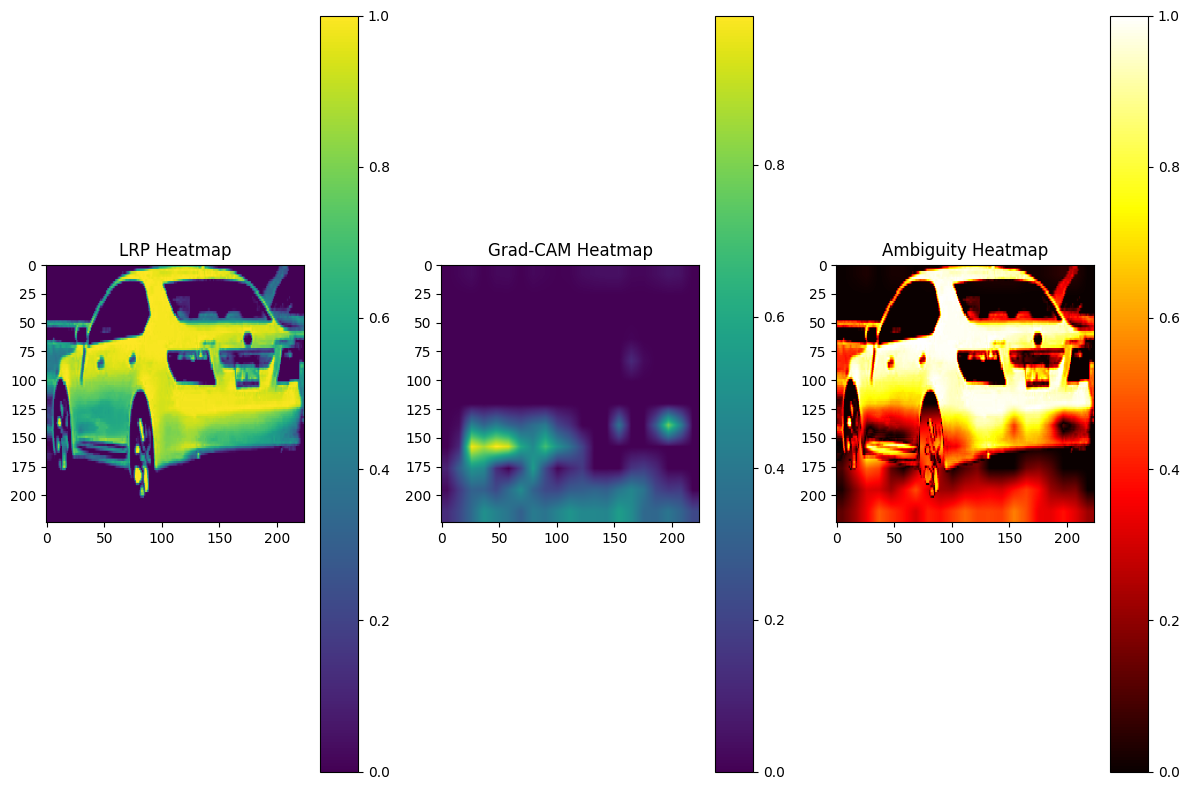

In [30]:
plt.figure(figsize=(12, 8))

# LRP Heatmap
plt.subplot(1, 3, 1)
plt.imshow(lrp_heatmap, cmap='viridis')
plt.colorbar()
plt.title('LRP Heatmap')

# Grad-CAM Heatmap
plt.subplot(1, 3, 2)
plt.imshow(gradcam_heatmap_resized, cmap='viridis')
plt.colorbar()
plt.title('Grad-CAM Heatmap')

# Ambiguity Heatmap
plt.subplot(1, 3, 3)
plt.imshow(ambiguity_heatmap, cmap='hot')
plt.colorbar()
plt.title('Ambiguity Heatmap')

plt.tight_layout()
plt.show()

Interpretability

In [31]:
lrp_heatmap_normalized = (lrp_heatmap - np.min(lrp_heatmap)) / (np.max(lrp_heatmap) - np.min(lrp_heatmap))
gradcam_heatmap_normalized = (gradcam_heatmap_resized - np.min(gradcam_heatmap_resized)) / (np.max(gradcam_heatmap_resized) - np.min(gradcam_heatmap_resized))


In [32]:
# One common approach is to use the element-wise product of the normalized heatmaps
interpretability_heatmap = lrp_heatmap_normalized * gradcam_heatmap_normalized

# Step 4: Normalize the interpretability heatmap to [0, 1]
interpretability_heatmap_normalized = (interpretability_heatmap - np.min(interpretability_heatmap)) / (np.max(interpretability_heatmap) - np.min(interpretability_heatmap))


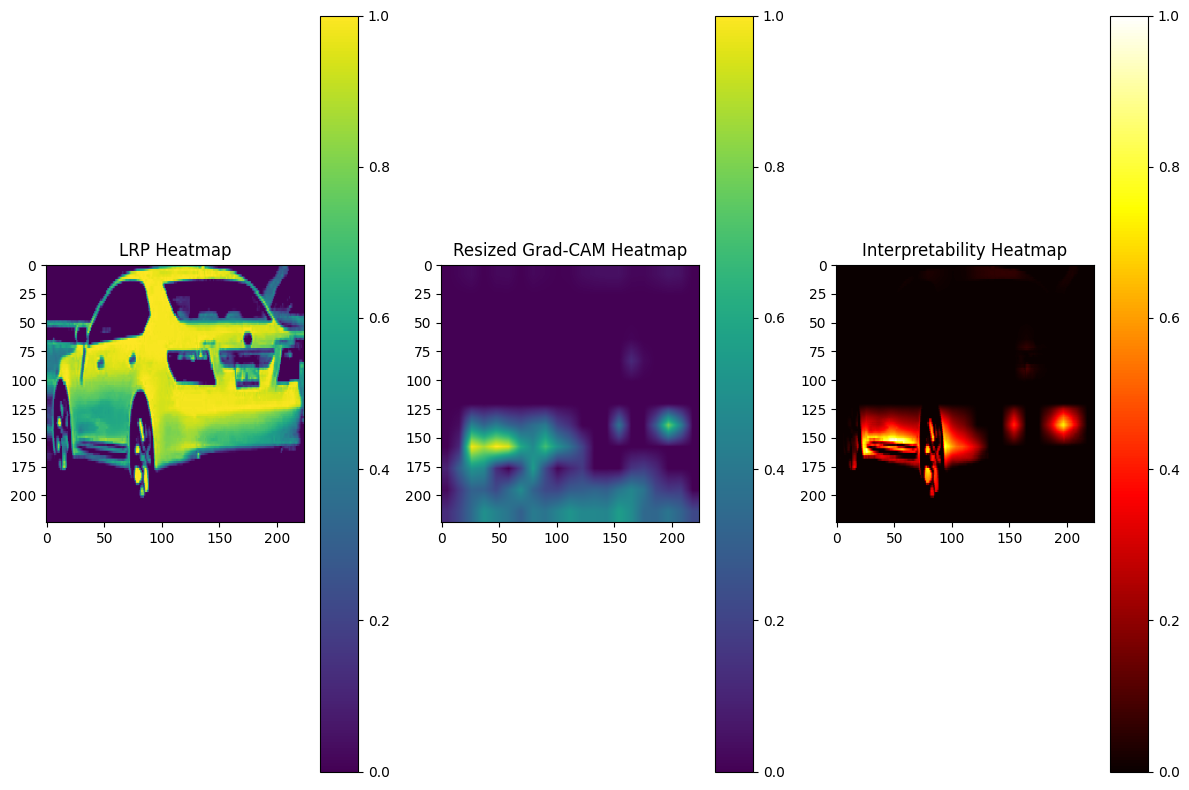

In [33]:
plt.figure(figsize=(12, 8))

# LRP Heatmap
plt.subplot(1, 3, 1)
plt.imshow(lrp_heatmap_normalized, cmap='viridis')
plt.colorbar()
plt.title('LRP Heatmap')

# Resized Grad-CAM Heatmap
plt.subplot(1, 3, 2)
plt.imshow(gradcam_heatmap_normalized, cmap='viridis')
plt.colorbar()
plt.title('Resized Grad-CAM Heatmap')

# Interpretability Heatmap
plt.subplot(1, 3, 3)
plt.imshow(interpretability_heatmap_normalized, cmap='hot')
plt.colorbar()
plt.title('Interpretability Heatmap')

plt.tight_layout()
plt.show()

Fidelity

In [34]:
# Step 3: Calculate Fidelity Metric
# Fidelity can be defined as the mean product of the two normalized heatmaps
fidelity_heatmap = lrp_heatmap_normalized * gradcam_heatmap_normalized

# Step 4: Normalize the fidelity heatmap to [0, 1]
fidelity_heatmap_normalized = (fidelity_heatmap - np.min(fidelity_heatmap)) / (np.max(fidelity_heatmap) - np.min(fidelity_heatmap))


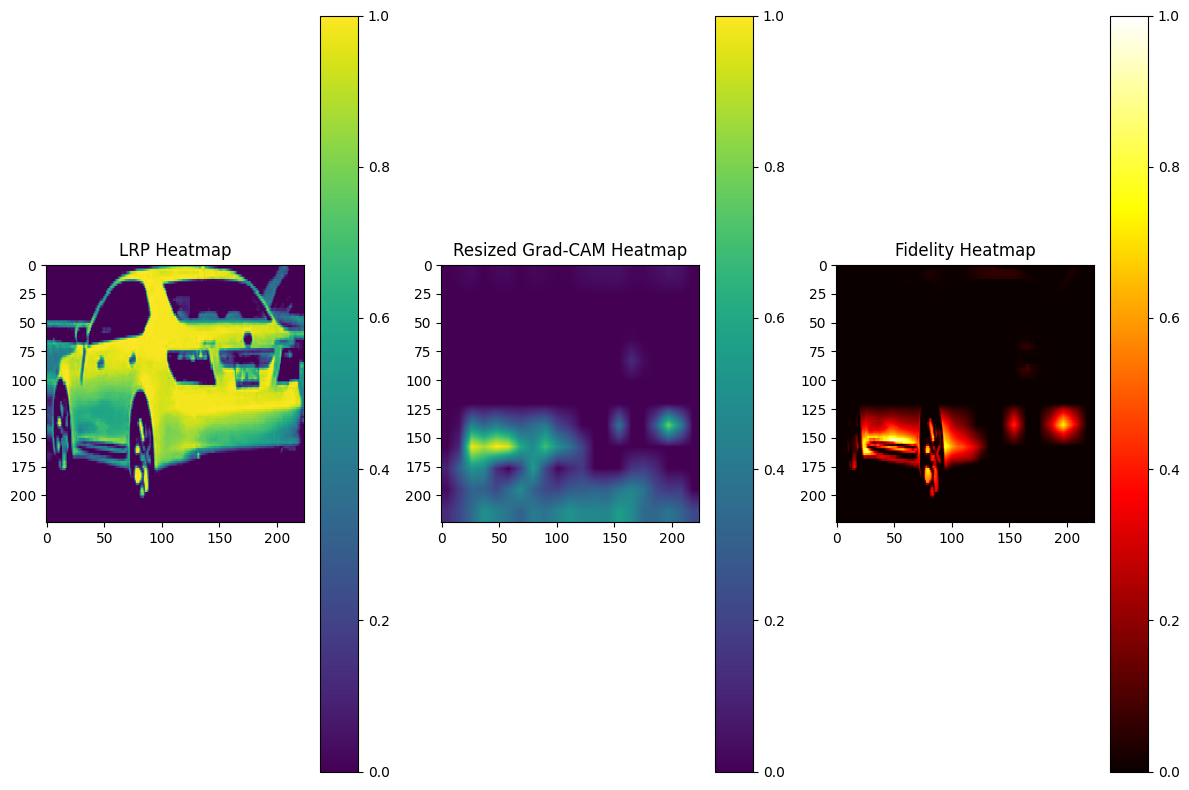

In [35]:
plt.figure(figsize=(12, 8))

# LRP Heatmap
plt.subplot(1, 3, 1)
plt.imshow(lrp_heatmap_normalized, cmap='viridis')
plt.colorbar()
plt.title('LRP Heatmap')

# Resized Grad-CAM Heatmap
plt.subplot(1, 3, 2)
plt.imshow(gradcam_heatmap_normalized, cmap='viridis')
plt.colorbar()
plt.title('Resized Grad-CAM Heatmap')

# Fidelity Heatmap
plt.subplot(1, 3, 3)
plt.imshow(fidelity_heatmap_normalized, cmap='hot')
plt.colorbar()
plt.title('Fidelity Heatmap')

plt.tight_layout()
plt.show()

Interpretability element wise

In [36]:
# One way to do this is to take the element-wise product of the normalized heatmaps
interpretability_metric = lrp_heatmap_normalized * gradcam_heatmap_normalized

# Step 4: Normalize the interpretability metric to [0, 1]
interpretability_metric_normalized = (interpretability_metric - np.min(interpretability_metric)) / (np.max(interpretability_metric) - np.min(interpretability_metric))


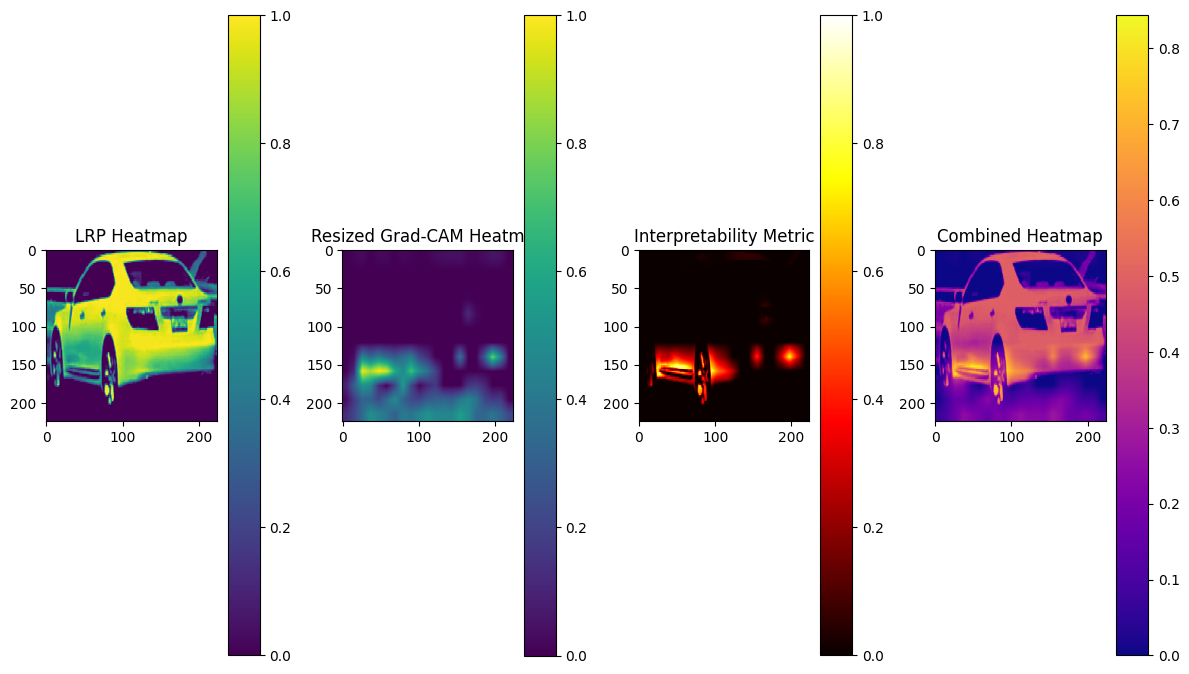

In [37]:
plt.figure(figsize=(12, 8))

# LRP Heatmap
plt.subplot(1, 4, 1)
plt.imshow(lrp_heatmap_normalized, cmap='viridis')
plt.colorbar()
plt.title('LRP Heatmap')

# Resized Grad-CAM Heatmap
plt.subplot(1, 4, 2)
plt.imshow(gradcam_heatmap_normalized, cmap='viridis')
plt.colorbar()
plt.title('Resized Grad-CAM Heatmap')

# Interpretability Metric
plt.subplot(1, 4, 3)
plt.imshow(interpretability_metric_normalized, cmap='hot')
plt.colorbar()
plt.title('Interpretability Metric')

# Combined Visualization
combined_heatmap = (lrp_heatmap_normalized + gradcam_heatmap_normalized) / 2
plt.subplot(1, 4, 4)
plt.imshow(combined_heatmap, cmap='plasma')
plt.colorbar()
plt.title('Combined Heatmap')

plt.tight_layout()
plt.show()

In [38]:
# Function to compute fidelity metrics
def calculate_fidelity_metrics(heatmap, method_name):
    print(f"Fidelity metrics for {method_name}:")

    # Example metric: Mean Activation
    mean_activation = heatmap.mean()
    print(f"Mean Activation: {mean_activation:.4f}")

    # Example metric: Max Activation
    max_activation = heatmap.max()
    print(f"Max Activation: {max_activation:.4f}")

    print("-" * 30)

In [65]:
# Function to compute interpretability metrics
def calculate_interpretability_metrics(heatmap, method_name):
    print(f"Interpretability metrics for {method_name}:")

    # Example metric: Simplicity (measured inversely by the number of non-zero regions)
    non_zero_regions = (heatmap > 0).sum()
    simplicity = 1 / non_zero_regions if non_zero_regions > 0 else None

    # Print simplicity in decimal form
    if simplicity is not None:
        print(f"Simplicity: {simplicity:.12f}")  # Adjust the number of decimal places as needed
    else:
        print("Simplicity: Undefined (No non-zero regions)")



    # Example metric: Saliency Ratio (ratio of maximum value to sum of values)
    saliency_ratio = heatmap.max() / heatmap.sum()
    print(f"Saliency Ratio: {saliency_ratio:.4f}")

    print("-" * 30)

In [66]:
# Calculate fidelity and interpretability metrics for Grad-CAM
gradcam_ambiguity=calculate_ambiguity_metrics(gradcam_heatmap_resized, "Grad-CAM")
gradcam_fidelity = calculate_fidelity_metrics(gradcam_heatmap_resized, "Grad-CAM")
gradcam_interpretability = calculate_interpretability_metrics(gradcam_heatmap_resized, "Grad-CAM")

Ambiguity metrics for Grad-CAM:
Sparsity: 0.0400
Variance: 0.0326
Entropy: 9.7559
------------------------------
Fidelity metrics for Grad-CAM:
Mean Activation: 0.1157
Max Activation: 0.9971
------------------------------
Interpretability metrics for Grad-CAM:
Simplicity: 0.000034851706
Saliency Ratio: 0.0002
------------------------------


In [67]:
# Calculate fidelity and interpretability metrics for LRP
lrp_ambiguity=calculate_ambiguity_metrics(lrp_heatmap_normalized, "LRP")
lrp_fidelity = calculate_fidelity_metrics(lrp_heatmap_normalized, "LRP")
lrp_interpretability = calculate_interpretability_metrics(lrp_heatmap_normalized, "LRP")


Ambiguity metrics for LRP:
Sparsity: 0.4039
Variance: 0.1658
Entropy: 10.0954
------------------------------
Fidelity metrics for LRP:
Mean Activation: 0.3754
Max Activation: 1.0000
------------------------------
Interpretability metrics for LRP:
Simplicity: 0.000036803945
Saliency Ratio: 0.0001
------------------------------


### Ambiguity Metrics:
- **Sparsity: 0.4039**
  - **Interpretation**: Sparsity indicates how much of the heatmap contains significant activations (non-zero values). A value of **0.4039** suggests that around 40.39% of the heatmap is non-zero, indicating a moderately sparse representation with significant regions but also many zero areas.

- **Variance: 0.1658**
  - **Interpretation**: Variance measures the spread of the activations within the heatmap. A variance of **0.1658** indicates some variability in activation values, suggesting differing intensity across the heatmap rather than uniform activation.

- **Entropy: 10.0954**
  - **Interpretation**: Entropy quantifies the amount of uncertainty or information content in the heatmap. A higher entropy value (like **10.0954**) suggests a complex distribution of activations, indicating diverse and non-predictable regions. This may suggest that the model makes decisions based on various parts of the input.

### Fidelity Metrics:
- **Mean Activation: 0.3754**
  - **Interpretation**: This value represents the average activation across the heatmap. A mean activation of **0.3754** indicates that, on average, the LRP method identifies a moderate level of relevance in its predictions.

- **Max Activation: 1.0000**
  - **Interpretation**: The maximum activation of **1.0000** indicates that the most relevant region of the input is at its highest possible value. This suggests that there are areas of the input that the LRP method considers extremely significant for the prediction.

### Interpretability Metrics:
- **Simplicity: 0.000036803945**
  - **Interpretation**: This value indicates the simplicity of the heatmap in terms of non-zero regions. A very small simplicity value like **0.0000368** suggests that the heatmap is quite complex, with very few non-zero regions, making it potentially less interpretable. This low value indicates that the model's decision-making process is not straightforward.

- **Saliency Ratio: 0.0001**
  - **Interpretation**: The saliency ratio indicates the concentration of the maximum value relative to the sum of all values in the heatmap. A saliency ratio of **0.0001** suggests that the model's attention is spread thin across the input, indicating it does not rely heavily on any single feature, potentially making it less interpretable.
